In [10]:
%matplotlib inline
#%pylab
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mpc
import matplotlib.dates as dts
import numpy as np
import pandas as pd
import itertools
import os
import datetime
from root_numpy import root2array, root2rec, tree2rec, array2root
plt.rcParams.update({'font.size': 16})

# useful variables:
# ADC->ENC -> ENC = ADC / ( 1.6E-4 [fC/e-] * 14 [mV/fC] * 1.935 [ADC/mV] )
ADCtoENC = 230.71

In [3]:
# load temperature information
# stored in .csv file as time, temp of 1st temp monitor, temp of 2nd temp monitor
temp_data = np.loadtxt('july2_temperature.csv',delimiter=',',
                        dtype={'names':('time','temp1','temp2'),
                                'formats':('S27','f4','f4')})

# function that, given a time, returns the temperature recorded at the nearest time to that provided as input
# return is a tuple of closest time, average temperature at this time, error on temperature
def getTempfromTime(time):

    #prepare may 20th datetime
    T0 = datetime.datetime.strptime('2015/05/20 00:00:00.0','%Y/%m/%d %H:%M:%S.%f')

    timeRet = 0
    
    #time format [Day,Hr,Min]
    # get minutes since May 20th, 2015
    mins = time[0]*24*60*60+time[1]*60*60+time[2]*60

    for n in xrange(len(temp_data)):
        #print temp_data['time'][n]
        time_sec = temp_data['time'][n].split('.')[0]
        #print time_sec
        t = datetime.datetime.strptime(str(time_sec),'%Y/%m/%d %H:%M:%S')
        timeRet = t
        # calculate minutes since May 20th, 2015
        dt = t-T0 #time interval since may 20h
        dt_sec = dt.total_seconds()
        if (dt_sec > mins):
            tempret = (temp_data['temp1'][n]+temp_data['temp2'][n])/2.
            temperr = (temp_data['temp1'][n]-temp_data['temp2'][n])/2.
            return [timeRet,tempret,temperr]
    # use last temperature saved if we couldn't find anything better
    tempret = (temp_data['temp1'][-1]+temp_data['temp2'][-1])/2.
    temperr = (temp_data['temp1'][-1]-temp_data['temp2'][-1])/2.
    print 'failed...%i:%i:%i'%(time[0],time[1],time[2])
    return [timeRet,tempret,temperr]


In [4]:
# given a file name containing noise measurements for a run
# return a pandas dataframe with noise information for that run
def getDF(filename):

    arr = np.loadtxt(filename,
                     dtype={'names':('crate','slot','femch','mean','rmsnoise'),
                            'formats':('i4','i4','i4','f4','f4')})

    df = pd.DataFrame(arr)
    
    return df

In [5]:
# various utility functions to get information from a data-frame

fracselected = []

# for a given channel, get the noise on that channel for a given run
def getMeanOneChan(df,cr,sl,fem):
    dfY = df.query('crate == %i and slot == %i and femch == %i'%(cr,sl,fem))
    rmsH = dfY['rmsnoise'].ravel()
    return np.average(rmsH)

# for collection plane wires get the avg and standard deviation of the RMS of the wires that pass these cuts:
# - rms > 0.1 (i.e. not 0)
# - baseline consistent with collection plane channel
# - rms for each channel > cutLow and < cutHigh
def getMeanAndRMS(df,cutLow,cutHigh):
    dfY = df.query('mean < 600 and rmsnoise > %f and rmsnoise < %f'%(cutLow,cutHigh))
    rmsH = dfY['rmsnoise'].ravel()
    return np.average(rmsH),np.std(rmsH)

# get distribution of all RMS values for wires with pedestal consistent with collection-plane pulse
def getYPlaneRMS(df,minRMS,maxRMS):
    quer = 'mean < 600'
    dfY = df.query(quer)
    rmsH = dfY['rmsnoise'].ravel()
    return rmsH

# get list of bad Y-plane channels with noise below or above some cut
def getBad(df,cutLow,cutHigh):
    dfY = df.query('mean < 600 and ( rmsnoise < %f or rmsnoise > %f ) and rmsnoise != 0.0'%(cutLow,cutHigh))
    badch = []
    for i, r in dfY.iterrows():
        crslch_rms = [r['crate'],r['slot'],r['femch'],r['rmsnoise']]
        badch.append(crslch_rms)
    return badch

# return [crate, slot, femch, rms ] for Y channels with noise above some cut
def getHigh(df,cutLow,cutHigh):
    dfY = df.query('mean < 600 and rmsnoise > %f and rmsnoise != 0.0'%(cutHigh))
    badch = []
    for i, r in dfY.iterrows():
        crslch_rms = [r['crate'],r['slot'],r['femch'],r['rmsnoise']]
        badch.append(crslch_rms)
    return badch

# return [crate, slot, femch, rms ] for Y channels with noise below some cut
def getLow(df,cutLow,cutHigh):
    dfY = df.query('mean < 600 and rmsnoise < %f and rmsnoise != 0.0'%(cutLow))
    badch = []
    for i, r in dfY.iterrows():
        crslch_rms = [r['crate'],r['slot'],r['femch'],r['rmsnoise']]
        badch.append(crslch_rms)
    return badch

In [7]:
runs = [190,191,192,197,205,214,215,216,217,218,\
        236,237,247,248,249,250,251,252,253,270,\
        271,272,273,274,275,276,278,279,280,281,\
        282,283,284,285,286,287,288,289,290,291,\
        292,293,294,295,296,297,298,299,300,301,\
        302,303,304,305,306,307,308,309,310,311,\
        312,313,314,315,316,317,318,319,320,321,\
        322,323,324,325,326,327,328,329,330,331,\
        332,333,334,335,336,337,338,339,340,341,\
        342,343,344,345,346,347,348,349,350,351,\
        352,353,354,355,356,357,358,359,360,361,\
        362,363,364,365,366,367,368,369,370,371,\
        372,373,374,375,376,381,382,383,384,385,\
        386,387,388,389,390,391,392,400,401,402,\
        416,441,442,443,444,445,447,449,450,459,\
        460,462,463,466,467,470,471,472,473,474,\
        475,476,477,478,480,481,482,483,484,485,\
        486,487,488,489,490,491,495,496,497,498,\
        499,500,501,502,503,504,505,506,507,509,\
        519,520,521,541,542,543,555,553,554,555,\
        561,564,565,567,569,571,572,574,576,577,\
        582,583,584,587,588,589]

# times of each run: this is a hacky system but has been vetted
# each run has a time listed as[hours,minutes,seconds] starting the counting from 00:00 on May 20th, 2015
times = [[0,9,40],[0,10,19],[0,17,30],[1,12,34],[2,10,9],[8,12,22],[8,14,34],[8,14,53],[8,15,28],[11,12,4],\
         [11,18,18],[12,0,47],[13,0,28],[13,2,29],[13,5,6],[13,7,10],[13,8,33],[13,10,20],[13,12,11],[15,11,19],\
         [15,13,27],[15,15,12],[15,15,29],[15,15,34],[15,15,39],[15,16,51],[15,19,24],[16,0,5],[16,2,6],[16,4,12],\
         [16,4,29],[16,5,1],[16,5,37],[16,8,55],[16,11,27],[16,13,18],[16,16,35],[16,17,20],[16,18,30],[16,20,5],\
         [16,22,5],[16,23,55],[17,2,0],[17,4,7],[17,6,0],[17,8,22],[17,10,27],[17,12,24],[17,14,27],[17,16,13],\
         [17,18,3],[17,20,2],[17,22,1],[18,0,7],[18,1,59],[18,3,57],[18,6,4],[18,8,19],[18,10,11],[18,12,24],\
         [18,14,25],[18,16,55],[18,19,9],[18,21,4],[18,23,14],[19,1,1],[19,2,54],[19,6,43],[19,7,43],[19,9,13],\
         [19,11,25],[19,13,14],[19,14,57],[19,15,12],[19,16,4],[19,17,21],[19,17,26],[19,17,39],[19,17,52],[19,17,59],\
         [19,20,44],[19,23,1],[20,0,33],[20,2,49],[20,4,35],[20,6,28],[20,8,11],[20,10,55],[20,10,59],[20,11,40],\
         [20,12,16],[20,12,54],[20,13,48],[20,14,18],[20,15,15],[20,15,21],[20,15,55],[20,18,19],[20,20,2],[20,22,2],\
         [21,0,1],[21,2,6],[21,4,21],[21,5,52],[21,8,3],[21,11,26],[21,13,23],[21,16,14],[21,18,6],[21,20,2],\
         [21,21,58],[22,0,2],[22,2,20],[22,4,18],[22,6,4],[22,10,23],[22,12,18],[22,14,20],[22,15,4],[22,18,43],\
         [22,22,59],[23,2,59],[23,7,10],[23,9,45],[23,10,33],[23,12,50],[23,23,11],[24,3,9],[24,7,56],[24,12,5],\
         [24,17,15],[24,20,56],[25,3,4],[25,7,2],[25,10,52],[25,15,4],[25,18,32],[26,4,45],[26,8,13],[26,12,12],\
         [27,0,29],[27,11,48],[27,18,39],[27,22,41],[28,1,4],[28,2,10],[28,5,49],[28,7,37],[28,8,15],[29,2,39],\
         [29,5,45],[29,7,31],[29,9,11],[29,18,59],[29,22,55],[30,8,25],[30,13,35],[30,18,15],[30,20,9],[30,23,38],\
         [31,3,4],[31,6,58],[31,11,42],[31,13,53],[31,18,33],[31,21,41],[32,1,59],[32,5,56],[32,9,16],[32,13,14],\
         [32,17,48],[32,22,5],[33,2,29],[33,6,17],[33,9,27],[33,11,16],[33,17,25],[33,19,20],[33,22,4],[34,1,56],\
         [34,5,28],[34,8,56],[34,12,12],[34,19,30],[34,22,44],[35,3,5],[35,6,37],[35,8,50],[35,12,11],[35,17,56],\
         [35,20,13],[35,23,2],[36,3,6],[37,1,49],[37,5,57],[37,9,1],[37,23,3],[38,1,19],[38,5,15],[38,10,30],\
         [38,23,8],[39,5,35],[39,10,4],[39,18,25],[40,2,2],[40,10,5],[40,13,52],[40,19,49],[41,3,12],[41,7,7],\
         [41,17,34],[42,7,55],[42,16,29],[42,23,22],[43,3,32],[43,6,59]]

# rms noise values found from files need to be multiplied by this value.
# this is always 1 (good!) except for a few runs, in which the measurement
# was performed incorrectly (basically value was erroneously divided by 2 and stored incorrectly in text file)
fact = [1,1,1,1,1,2,2,2,2,1,\
        1,1,1,1,1,1,1,1,1,1,\
        1,1,1,1,1,1,1,1,1,1,\
        1,1,1,1,1,1,1,1,1,1,\
        1,1,1,1,1,1,1,1,1,1,\
        1,1,1,1,1,1,1,1,1,1,\
        1,1,1,1,1,1,1,1,1,1,\
        1,1,1,1,1,1,1,1,1,1,\
        1,1,1,1,1,1,1,1,1,1,\
        1,1,1,1,1,1,1,1,1,1,\
        1,1,1,1,1,1,1,1,1,1,\
        1,1,1,1,1,1,1,1,1,1,\
        1,1,1,1,1,1,1,1,1,1,\
        1,1,1,1,1,1,1,1,1,1,\
        1,1,1,1,1,1,1,1,1,1,\
        1,1,1,1,1,1,1,1,1,1,\
        1,1,1,1,1,1,1,1,1,1,\
        1,1,1,1,1,1,1,1,1,1,\
        1,1,1,1,1,1,1,1,1,1,\
        1,1,1,1,1,1,1,1,1,1,\
        1,1,1,1,1,1,1,1,1,1,\
        1,1,1,1,1,1]

# lower bound cut for low-noise channels
# decreases with temperature decrease
cut = [2,2,2,2,2,1,1,1,1,1.5,\
       1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,\
       1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,\
       1,1,1,1,1,1,1,1,1,1,\
       1,1,1,1,1,1,1,1,1,1,\
       1,1,1,1,1,1,1,1,1,1,\
       1,1,1,1,1,1,1,1,1,1,\
       1,1,1,1,1,1,1,1,1,1,\
       1,1,1,1,1,1,1,1,1,1,\
       1,1,1,1,1,1,1,1,1,1,\
       1,1,1,1,1,1,1,1,1,1,\
       1,1,1,1,1,1,1,1,1,1,\
       1,1,1,1,1,1,1,1,1,1,\
       1,1,1,1,1,1,1,1,1,1,\
       1,1,1,1,1,1,1,1,1,1,\
       1,1,1,1,1,1,1,1,1,1,\
       1,1,1,1,1,1,1,1,1,1,\
       1,1,1,1,1,1,1,1,1,1,\
       1,1,1,1,1,1,1,1,1,1,\
       1,1,1,1,1,1,1,1,1,1,\
       1,1,1,1,1,1,1,1,1,1,\
       1,1,1,1,1,1]

# vector to hold temperature for each run
temps = []
# vector to hold error on temperature measured
terrors = []
# vector to hold time of run
runtimes = []
for t in times:
    treturn = getTempfromTime(t)
    runtimes.append(treturn[0])
    temps.append(treturn[1])
    terrors.append(treturn[2])

# convert times to a format that can be used for x-axis
dates = dts.date2num(runtimes)

In [8]:
# vector holding the avg RMS measured for a run
avg_v = []
# standard deviation of distribution of rms values
rms_v = []
# run numbers
runs_v = []
# times
time_v = []

import os

for r in xrange(len(runs)):
    fname = 'temp_mon_%i_detail.txt'%runs[r]
    #print fname
    if (os.path.isfile(fname)):
        df = getDF(fname)
        avg,rms = getMeanAndRMS(df,cut[r],5)
        avg_v.append(avg*fact[r])
        rms_v.append(rms*fact[r])
        runs_v.append(runs[r])
        time = times[r][0]+times[r][1]/24.+times[r][2]/(24*60)
        time_v.append(time)
    else:
        print fname

print len(avg_v)

216


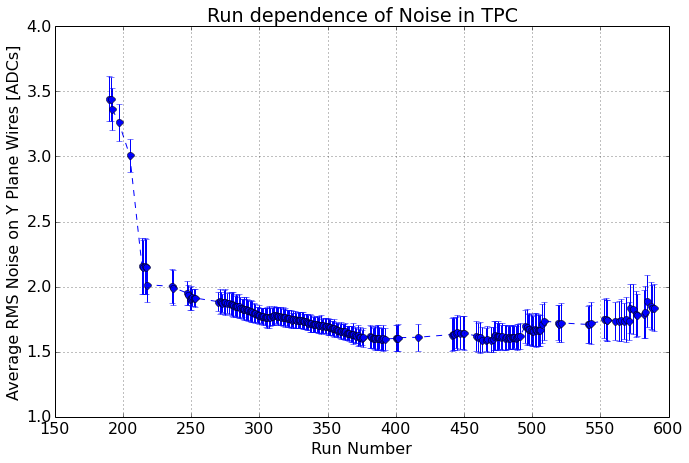

In [11]:
plt.figure(figsize=(11,7))
plt.errorbar(runs_v,avg_v,yerr=rms_v,fmt='o--',color='b',markersize=7)
plt.grid()
plt.xlabel('Run Number')
plt.ylabel('Average RMS Noise on Y Plane Wires [ADCs]')
plt.title('Run dependence of Noise in TPC')
plt.show()

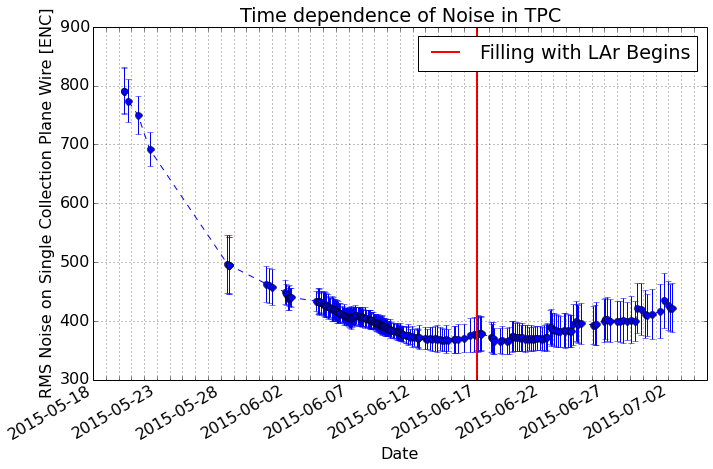

In [16]:
years    = dts.YearLocator()   # every year                                                                                                  
months   = dts.MonthLocator()  # every month                                                                                                 
days     = dts.DayLocator()
hours    = dts.HourLocator()
daysFmt  = dts.DateFormatter('%Y-%m-%d')

fig, ax = plt.subplots(figsize=(11,7))
plt.errorbar(dates,230*np.array(avg_v),yerr=230*np.array(rms_v),fmt='o--',color='b',markersize=7)
plt.grid()
ax.set_xlim([datetime.datetime.strptime('2015/05/18','%Y/%m/%d'),
             datetime.datetime.strptime('2015/07/05','%Y/%m/%d')])
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(daysFmt)
plt.xlabel('Date')
#plt.ylabel('Average RMS Noise on Y Plane Wires [ADCs]')
#plt.ylabel('Average RMS Noise on Collection Plane Wires [ENC]')
plt.ylabel('RMS Noise on Single Collection Plane Wire [ENC]')
plt.title('Time dependence of Noise in TPC')
ax.format_xdata = dts.DateFormatter('%Y-%m-%d')

filltime = datetime.datetime.strptime('2015/06/17','%Y/%m/%d')
filldate = dts.date2num(filltime)
plt.axvline(filldate,color='r',lw=2,label='Filling with LAr Begins')
plt.legend()

ctr = 0
for label in ax.xaxis.get_ticklabels():
    if (ctr%5 != 0):
        label.set_visible(False)
    ctr += 1
fig.autofmt_xdate()
#plt.xlim([30,40])
#plt.ylim([300,800])
plt.savefig('plots/noise_vs_time.png')
plt.savefig('plots/noise_vs_time.pdf')
plt.show()
#print time_v

In [30]:
# try and extract temperature dependence of noise
xarr = np.array(temps[:-60])
yarr = np.array(avg_v[:-60])*230
earr = np.array(rms_v[:-60])*230
from scipy.optimize import curve_fit
def func(x,n,b):
    return b+n*x**3
popt,popv = curve_fit(func,xarr,yarr,sigma=earr)
print popt
print popv

[  1.39212575e-05   3.33072969e+02]
[[  8.53444972e-14  -4.14906374e-07]
 [ -4.14906374e-07   2.58438709e+00]]


216
216
216
216


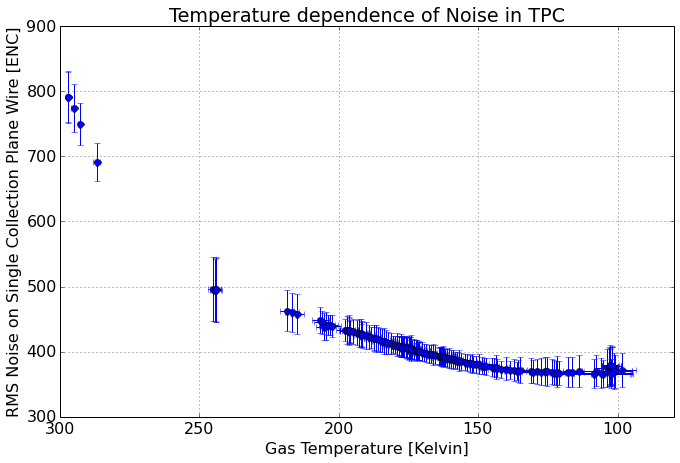

In [13]:
fig,ax = plt.subplots(figsize=(11,7))
print len(rms_v)
print len(terrors)
print len(temps)
print len(avg_v)
plt.errorbar(temps[:-60],230*np.array(avg_v[:-60]),xerr=terrors[:-60],yerr=230*np.array(rms_v[:-60]),\
            fmt='o',color='b',markersize=7)
#plt.plot(temps[:-60],230*np.array(avg_v[:-60]),'ob',markersize=7)
#plt.fill_between(temps[:-60],\
##                 230*(np.array(avg_v[:-60])-np.array(rms_v[:-60])),\
#                 230*(np.array(avg_v[:-60])+np.array(rms_v[:-60])),\
#                 facecolor='b', alpha=0.2, edgecolor='none')
xpts = np.linspace(100,300,100)
#plt.plot(xpts,popt[0]*xpts**3+popt[1],'r-')
#plt.plot(temps,avg_v)
#plt.errorbar(temps_IFIX192,avg_v,yerr=rms_v,fmt='o',color='b',markersize=7,label='IFIX 192')
#plt.errorbar(temps_TE856,avg_v,yerr=rms_v,fmt='o',color='r',markersize=7,label='TE 856 Temp')
plt.grid()
ax.set_xlabel('Gas Temperature [Kelvin]')
#ax.set_ylabel('Average RMS Noise on Y Plane Wires [ADCs]')
#ax.set_ylabel('Average RMS Noise on Collection Plane Wires [ENC]')
ax.set_ylabel('RMS Noise on Single Collection Plane Wire [ENC]')
plt.title('Temperature dependence of Noise in TPC')
ax.invert_xaxis()
#plt.legend()
plt.xlim([300,80])
#plt.ylim([300,800])
plt.savefig('plots/noise_vs_temp.png')
plt.savefig('plots/noise_vs_temp.pdf')
plt.show()
#print time_v

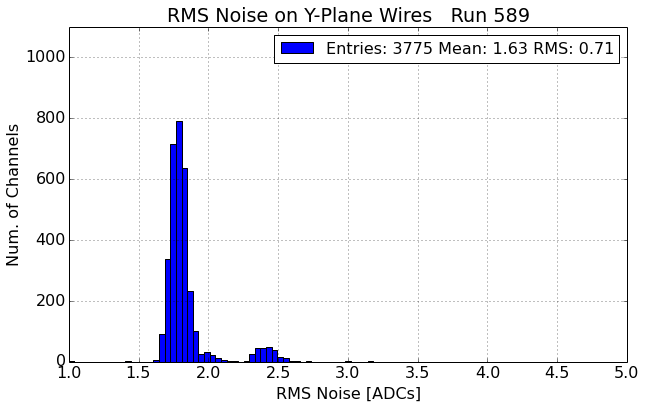

In [14]:
# this block of code makes a movie showing the distribution of noise values for selected channels
# for all runs

from matplotlib import animation

fig = plt.figure(figsize=(10,6))
ax = plt.subplot()

rms_arr = [3]

def init():
    im = plt.hist(rms_arr,bins=np.linspace(1,5,100),\
                  label='Entries: %i Mean: %.02f RMS: %.02f'%(len(rms_arr),np.average(rms_arr),np.std(rms_arr)))
    ax.set_xlabel('RMS Noise [ADCs]')
    ax.set_ylabel('Num. of Channels')
    plt.title('RMS Noise on Y-Plane Wires')
    plt.legend(fontsize=16)
    plt.xlim([1,5])
    plt.ylim([0,1300])
    plt.grid()
    return im

def animate(i):
    ax.cla()
    fname = 'temp_mon_%i_detail.txt'%runs[i]
    if (os.path.isfile(fname)):
        df = getDF(fname)
        #rms_arr = getYPlaneRMS(df,1,10)
        rms_arr = fact[i]*getYPlaneRMS(df,cut[i],5)
        im = plt.hist(rms_arr,bins=np.linspace(1,5,100),\
                      label='Entries: %i Mean: %.02f RMS: %.02f'%(len(rms_arr),np.average(rms_arr),np.std(rms_arr)))
        ax.set_xlabel('RMS Noise [ADCs]')
        ax.set_ylabel('Num. of Channels')
        plt.title('RMS Noise on Y-Plane Wires   Run %i'%runs[i])
        plt.legend(fontsize=16)
        plt.ylim([0,1100])
        plt.xlim([1,5])
        plt.grid()
        return im

anim = animation.FuncAnimation(fig,animate,init_func=init,frames=len(runs),interval=500,blit=True)
anim.save('noise_all.mp4',writer='avconv',fps=2,codec='libx264',bitrate=-1)


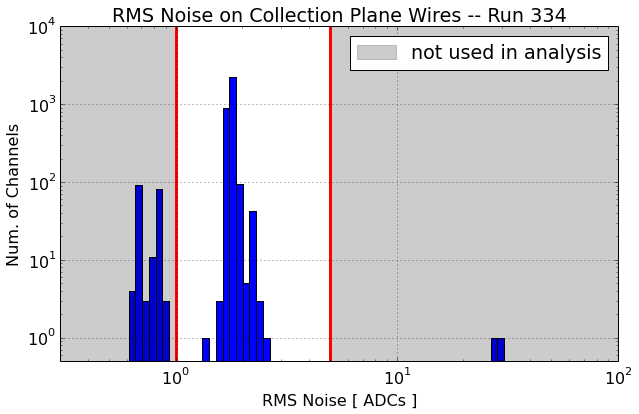

In [15]:
# simple script to make histogram of all noise values on y-plane channels

r = 462
fname = 'temp_mon_%i_detail.txt'%300
if (os.path.isfile(fname)):
    df = getDF(fname)
    rms_arr = getYPlaneRMS(df,0.3,100)#*fact[r]
    #rms_arr = getMeanAndRMS(df,0.1,100)[0]
    fig = plt.figure(figsize=(10,6))
    plt.title('RMS Noise on Collection Plane Wires -- Run 334')
    plt.ylabel('Num. of Channels')
    plt.xlabel('RMS Noise [ ADCs ]')
    plt.hist(rms_arr, bins=np.logspace(-1,2,100))
    #plt.legend(fontsize=16)
    plt.xlim([0.3,100])
    plt.yscale('log',nonposy='clip')
    plt.ylim([0.5,10000])
    plt.axvline(1,color='r',lw=3)
    plt.axvline(5,color='r',lw=3)
    plt.axvspan(0.1,1,color='k',alpha=0.2)
    plt.axvspan(5,100,color='k',alpha=0.2,label='not used in analysis')
    plt.legend(loc=1)
    plt.gca().set_xscale('log')
    plt.grid()
    plt.savefig('plots/all_noise.png')
    plt.savefig('plots/all_noise.pdf')
    plt.show()